In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
import plotly.plotly as py
import plotly.graph_objs as go

## Intro

In [2]:
Image(url = "http://cdn2.hubspot.net/hubfs/513976/Blog_Featured_Images/Drowning-in-Data.jpg")

In [3]:

Image(url= "https://i.pinimg.com/originals/53/04/50/530450a146551ec2e8a4a2e7c1104c1d.jpg")

# Question - 1,  2 

1. Customers often visit us in multiple ways (both through our website and via calls and emails with our gearhead sales team) prior to purchase. Considering this customer journey, how would you recommend <strong>attributing</strong> sales among the various channels? 

2. What method/s did you use for your <strong>attribution</strong> calculations?


###  Part 1 : 

### Obtaining the data 

In [4]:
## import necessary libraries


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import groupby
import numpy as np
import seaborn as sns

%matplotlib inline

### Meta Data

- ghx_<strong>Sales</strong> - sales data 30 days - order level with timestamp / last channel
- ghx_<strong>connections</strong> - connection data current connections with start time.  Showing when customer became connected to a gearhead expert.
- ghx_<strong>visits</strong> - Site visit data for 75 days - shows visit data with timestamp, customer number and channel from which they visited
- ghx_<strong>contacts</strong> - contact data - phone and email from gearheads to and from customers
- ghx_<strong>customerprofile</strong> - Customer data include customer zip, city, state, customer tenure

In [9]:
## Read all the available data


customer_profile = pd.read_csv("data/ghx_CustomerProfile.csv", encoding="ISO-8859-1")
customer_connections = pd.read_csv("data/ghx_CustomerConnections.csv",encoding="ISO-8859-1")
sales = pd.read_csv("data/ghx_Sales.csv",encoding="ISO-8859-1")
visits = pd.read_csv("data/ghx_visits.csv",encoding="ISO-8859-1")
contacts = pd.read_csv("data/ghx_Contacts.csv",encoding="ISO-8859-1")

In [10]:
sales.head()

,CUSTOMER_ID,ORDER_SOURCE_CATEGORY,ORDER_DATE,STATUS,ORDER_NUMBER,SALES,QTY
0,2072720,Website,09/04/2017 11:57:47 AM,shipped,b2680597971,291.71,1
1,108692750,Website,09/21/2017 09:48:42 PM,shipped,b2687905745,224.95,1
2,109029940,Website,09/20/2017 09:41:48 AM,shipped,b2654154330,360.00,2
3,3781555,Website,09/22/2017 10:30:43 AM,shipped,b2153222116,530.00,4
4,912502020,Website,09/13/2017 03:39:28 PM,shipped,b2684490086,140.00,1


In [11]:
visits.head()

,WEBSITE_NM,CHANNEL_NAME,VISIT_END_DATE_DT,USER_ID,VISITOR_ID
0,Backcountry,Organic,08/02/2017 09:28:05 AM,106123308,30286230817960885204611687142098244773
1,Backcountry,PLA,08/03/2017 12:14:58 PM,106123308,31524714294527304834611692665426355009
2,Backcountry,Affiliate,08/05/2017 09:15:52 AM,106123308,31524714294527304834611692665426355009
3,Backcountry,PLA,08/05/2017 12:00:00 AM,106123308,31524714294527304834611692665426355009
4,Backcountry,Organic,08/08/2017 07:37:39 AM,106123308,30286230817960885204611687142098244773


### Part 2 : 

### Scrubbing the Data


1. Removing duplicate records from Visits data
2. Generating dataset by number of visits made by visitor before each purchase  

<strong>2.1 Fixing column values

In [6]:
## Exploring available channels


set(visits["CHANNEL_NAME"])

{'Affiliate',
 'App',
 'Branded Paid Search',
 'Direct',
 'Display Media',
 'Domain',
 'Domains',
 'Email',
 'General Referring Domains',
 'Non-Branded Paid Search',
 'Not Classified',
 'ODAT Ads',
 'Organic',
 'Other',
 'PLA',
 'Prospecting',
 'Shopping Search',
 'Social Media',
 'Vendor Links',
 'Video',
 'odaT Ads'}

In [7]:
## cleaning channel names


# This action is performed because while creating markov model in R, 
# there are issues with spaces in the channel names 

def clean_channel_name(row):
    return row.lower().replace(" ","-")

visits["CHANNEL_NAME"] = visits["CHANNEL_NAME"].apply(clean_channel_name)

<strong>2.2 Checking and removing duplicate records

In [8]:
## grouping it by all the columns to get size of duplicate records in visits table


duplicate_visits_count = visits.groupby(["WEBSITE_NM","CHANNEL_NAME","VISIT_END_DATE_DT",
                                         "USER_ID","VISITOR_ID"]).size().reset_index(name = "count")

## sorting by freq of duplicates 


duplicate_visits_count.sort_values(by = "count", ascending= False).head(10)

,WEBSITE_NM,CHANNEL_NAME,VISIT_END_DATE_DT,USER_ID,VISITOR_ID,count
532280,Backcountry,domains,08/05/2017 03:19:06 AM,727053495,32252818131446216736917548398480461860,408
738443,Backcountry,email,10/04/2017 01:55:51 AM,110184483,32327586038826311856917548279295117457,277
258388,Backcountry,direct,09/03/2017 12:36:08 AM,3957038,32306942042295063694611705383361184505,263
1108539,Backcountry,pla,09/03/2017 03:21:29 AM,110029394,31563568737629638134611687152835625403,230
351582,Backcountry,direct,10/04/2017 11:51:38 PM,108081322,32366220558144294856917548306675538715,230
532218,Backcountry,domains,08/04/2017 08:26:53 PM,727053495,32252818131446216736917548398480461860,220
531810,Backcountry,display-media,10/14/2017 12:16:22 PM,1980267,32249280044762034424611705383361190497,207
116673,Backcountry,branded-paid-search,08/23/2017 02:46:08 PM,110012893,32287669042274230684611705296388109596,204
152077,Backcountry,direct,08/04/2017 12:48:12 PM,1327158996,32248378659975471816917548398480461432,202
532263,Backcountry,domains,08/04/2017 10:07:09 PM,727053495,32252818131446216736917548398480461860,187


In [14]:
## Summarizing number of rows, columns before and after deduping


rows = visits.shape[0] 
visits = visits.drop_duplicates(keep ="first")

rows_no_dup = visits.shape[0] 
columns = visits.shape[1]
column_names = list(visits.columns)

print("Number of actually rows : %d \nNumber of unique rows : %d \nNumber of Columns:  %d \nColumns: %s "
      %(rows, rows_no_dup, columns ,column_names))
print("")
print("Percentage of duplicate records in Visits data: %f" %(rows_no_dup * 100/ rows))

Number of actually rows : 3492947 
Number of unique rows : 1210049 
Number of Columns:  5 
Columns: ['WEBSITE_NM', 'CHANNEL_NAME', 'VISIT_END_DATE_DT', 'USER_ID', 'VISITOR_ID'] 

Percentage of duplicate records in Visits data: 34.642638


<strong>2.3 categorizing the dataset by number of visits made by visitor before each purchase 

In [12]:
# ## looping through each customer id to get in sales and checking how many visits 
# ## they made before that purchase to create dataset for markov chain model


# list_of_dfs = []

# for num, cid in enumerate(set(sales["CUSTOMER_ID"])):
#     order_dates = list(sales[sales["CUSTOMER_ID"] == cid]["ORDER_DATE"])
#     for order_num, order_date in enumerate(order_dates):
#         one_customer_visit_df = visits[visits["USER_ID"] == cid]
#         visits_before_purchase_df = one_customer_visit_df[one_customer_visit_df["VISIT_END_DATE_DT"] <= order_date]
#         visits_before_purchase_df["PURCHASE_ORDER_NUM"] = order_num
#         list_of_dfs.append(visits_before_purchase_df)
        
# final = pd.concat(list_of_dfs)
# final.to_csv("data/purchase_order_num.csv")

In [13]:
final = pd.read_csv("data/purchase_order_num.csv", index_col=0)

In [14]:
## creating new user id to identify how many orders one placed based on that
 

final["PURCHASE_ORDER_NUM"] = final["PURCHASE_ORDER_NUM"] +1
final["NEW_USER_ID"] = final["USER_ID"].astype(str) + "-" + final["PURCHASE_ORDER_NUM"].astype(str)

In [15]:
## merging it with visits data


visits_joined = pd.merge(visits, final, on =["WEBSITE_NM","CHANNEL_NAME",
                                             "VISIT_END_DATE_DT", "USER_ID","VISITOR_ID"], how = "left")
visits_joined["PURCHASE_ORDER_NUM"]= visits_joined["PURCHASE_ORDER_NUM"].fillna(0)
visits_joined["NEW_USER_ID"] = visits_joined["NEW_USER_ID"].fillna(visits_joined
                    ["USER_ID"].astype(str) + "-"+ visits_joined["PURCHASE_ORDER_NUM"].astype(str))

In [16]:
## seperating converted users and non converted users

 
visits_sales_df = pd.merge(visits_joined, sales, right_on="CUSTOMER_ID", left_on="USER_ID", how = "left")
converted_visits_sales_df = visits_sales_df[visits_sales_df.ORDER_NUMBER.notnull()].reset_index(drop = True)
non_converted_visits_sales_df = visits_sales_df[~visits_sales_df.ORDER_NUMBER.notnull()].reset_index(drop = True)

converted_visits_sales_df = visits_sales_df[visits_sales_df.ORDER_NUMBER.notnull()].reset_index(drop = True)
non_converted_visits_sales_df = visits_sales_df[~visits_sales_df.ORDER_NUMBER.notnull()].reset_index(drop = True)

In [17]:
# filtering out unnecessary columns


converted_visits_sales_df = converted_visits_sales_df[["USER_ID","CHANNEL_NAME",
                                                       "NEW_USER_ID","VISIT_END_DATE_DT","ORDER_NUMBER"]]
non_converted_visits_sales_df = non_converted_visits_sales_df[["USER_ID","CHANNEL_NAME",
                                                               "NEW_USER_ID","VISIT_END_DATE_DT","ORDER_NUMBER"]]

In [18]:
## grouping by USER_ID to generate vistior path


converted_user_path = converted_visits_sales_df.groupby(["NEW_USER_ID"])["CHANNEL_NAME"].apply(lambda x: ' > '.join(x)).reset_index()
non_converted_user_path = non_converted_visits_sales_df.groupby(["NEW_USER_ID"])["CHANNEL_NAME"].apply(lambda x: ' > '.join(x)).reset_index()

converted_user_path["conv"] = 1
converted_user_path["no_conv"] = 0

non_converted_user_path["conv"] = 0 
non_converted_user_path["no_conv"] = 1

user_path_df = pd.concat([converted_user_path, non_converted_user_path]).reset_index(drop = True).drop("NEW_USER_ID", axis = 1)

#### Final data set with user path

In [19]:
## user_path_df sample


user_path_df.sample(50)

,CHANNEL_NAME,conv,no_conv
162041,direct > pla > pla > pla > pla > direct > pla,0,1
152454,organic > direct > direct,0,1
37693,pla > pla > pla > pla > pla > pla > organic > ...,1,0
63730,pla > organic > organic > pla > pla > pla > pl...,1,0
53594,email > email > email > email > email > email ...,1,0
140878,direct > direct > direct > direct,0,1
30579,direct > direct > direct > direct > direct > d...,1,0
73108,direct > direct > direct > direct > direct > d...,1,0
148049,pla > organic > pla,0,1
38341,direct > organic > affiliate > email > email >...,1,0


In [21]:
## writing to user_path data to csv


user_path_df.to_csv("data/user_path_df.csv", index= None)

 ### Part 3 : 

### Building the model : Markov Chain Model

This dataset has been used to get attribution by markov model in R.


<strong>What is Markov Chain Model?</strong>

- A Probabilistic Model
- Each Marketing Channel is represented by each vertex in Markov Chain and edge is Probability of transistion between channels


<strong>What is used here?</strong>

- Used "memory-free" or "first-order" Markov Graph

In [23]:
%%html
<style>
table {float:left}
</style>

### Example of Markov Chain Model

<strong>Channels : </strong>

Paid, Organic, Email


<strong>Customer Journey:</strong>

| Path | Result |
| :-------- | --------:|
| Paid -> Organic -> Email | purchase |
| Paid | no conversion |
| Organic -> Email| no conversion |


### Methodology

Build Chain:

1. Add Start and Conversion/Null to the Paths 
2. Split paths into pairs
3. Calculate transition probablity from one state to state

Example:

(start) -> Paid -> Organic -> Email -> (conversion)



(start) -> Paid, Paid -> Organic, Organic -> Email, Email -> (conversion)

|from	| to	| probability	
| :-------- | --------:|
|(start)	| Paid	| 2/3	
|(start)	| Organic	|   1/3	
|Paid |	Organic	|1/2	
|Paid	|(null)|	1/2	
|Organic	|Email	|1/2
|Email	|(conversion)|	1/2 
|Email	|(null)	|1/2

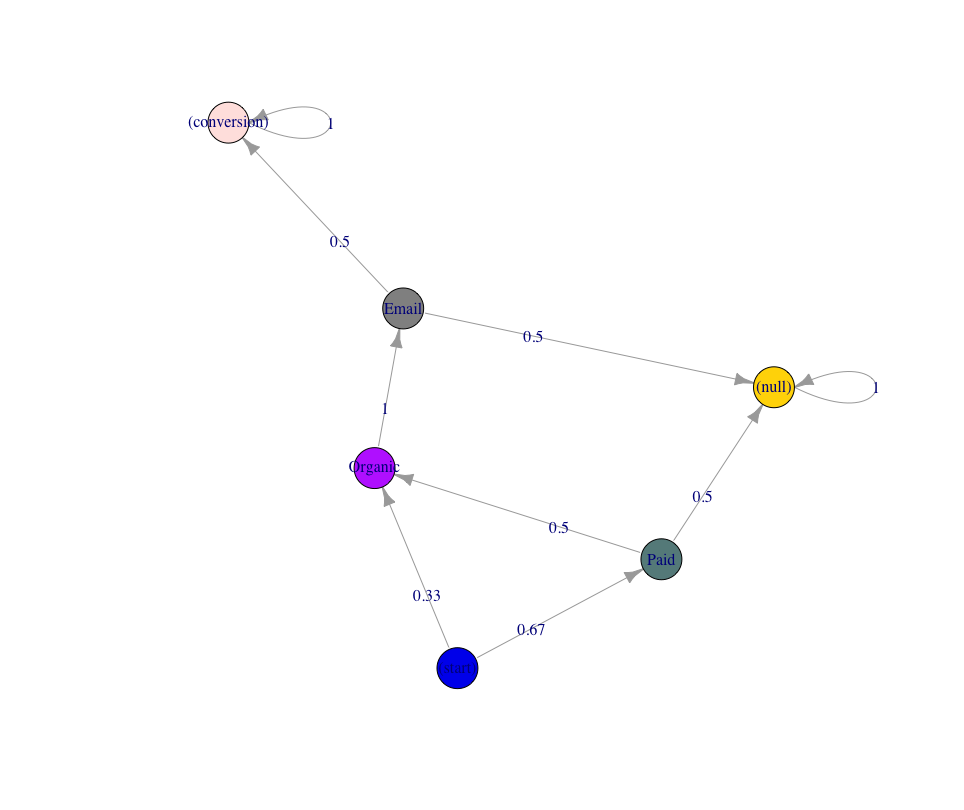

In [24]:
Image(filename="images/sample_markov_chain.png")

### Removal Effect


Removing each channel from the chain and estimating how many conversion are made without that channel


<strong>Example :</strong>

Probability of conversion = 33.3% =  (0.667 x 0.5 x 1 x 0.5 + 0.333 x 1 x 0.5)<br> 
Probability of conversion after removing the Paid channel = 16.7% = (0.333 x 1 x 0.5)

Removal Effect =  0.5 or 50%  = 1 – (0.167 / 0.333)

Removate Effect of Organic and Email is 1 or 100%

### Attribution

How attributions are calculated 

Attribution for a channel = no. of conversions x (Removal Effect of that Channel / Total Removal Effect )

Paid = 0.2<br>
Organic =  0.4<br>
Email = 0.4<br>

Total = 1 


### Part 4 : 

### Comparision with other Attribution Models

In [4]:
markov_chain_results = pd.read_csv("data/markov_chain_result.csv", index_col= 0)

In [26]:
## function to generate last columns of the user paths in each case


def get_attribution(row):
    channels = row["CHANNEL_NAME"].split(">")
    row["first_click"] = channels[0].strip()
    row["last_click"] = channels[-1].strip()
    try:
        row["last_non_direct_click"] = channels[-2].strip()
    except:
        row["last_non_direct_click"] = channels[-1].strip()
    return row

#applying function on the data

user_path_df = user_path_df.apply(get_attribution, axis = 1)

In [27]:
## Creating a summary dataframe of different attribution types


first_click = pd.DataFrame(user_path_df[user_path_df["conv"] == 1]["first_click"].
             value_counts()).reset_index().rename(columns = {"index":"channel"})

last_click = pd.DataFrame(user_path_df[user_path_df["conv"] == 1]["last_click"].
             value_counts()).reset_index().rename(columns = {"index":"channel"})

last_non_direct_click = pd.DataFrame(user_path_df[user_path_df["conv"] == 1]["last_non_direct_click"].
             value_counts()).reset_index().rename(columns = {"index":"channel"})

summary = pd.merge(first_click, last_click, on = "channel",
         how = "inner").merge(last_non_direct_click, on = "channel", how = "inner")

#### Grouped bar plot

In [28]:

def strip_white(row):
    return row.strip()

markov_chain_results = markov_chain_results.rename(columns = {"channel_name":"channel", "total_conversions":"markov_chain"})
markov_chain_results.channel = markov_chain_results.channel.astype(str).apply(strip_white)
markov_chain_results = markov_chain_results.sort_values(by = "markov_chain", ascending= False)

In [29]:
summary = pd.merge(markov_chain_results, summary, on = "channel", how = "left").fillna(0)
summary = summary.set_index("channel")

### Markov Chain Attribution Results & Comparison

In [46]:
summary.head(10)

,markov_chain,first_click,last_click,last_non_direct_click,markov_chain-first_click,markov_chain-last_click,markov_chain-last_non_direct_click
channel,,,,,,,
direct,17221.141953,22163.0,27366.0,25449.0,-22.297785,-37.071030,-32.330772
organic,16570.959619,18268.0,17292.0,17564.0,-9.289689,-4.169792,-5.653840
pla,14710.975674,15918.0,13186.0,14028.0,-7.582764,11.565112,4.868660
email,14567.233437,14352.0,14503.0,14721.0,1.499676,0.442898,-1.044539
display-media,11122.024648,7706.0,6904.0,7251.0,44.329414,61.095374,53.386080
affiliate,10545.570248,9057.0,7866.0,8057.0,16.435577,34.065221,30.887058
branded-paid-search,4309.840874,3533.0,3860.0,3844.0,21.988137,11.653909,12.118649
non-branded-paid-search,3826.078678,2711.0,2852.0,2838.0,41.131637,34.154231,34.816021
social-media,1025.060900,465.0,422.0,458.0,120.443204,142.905427,123.812424


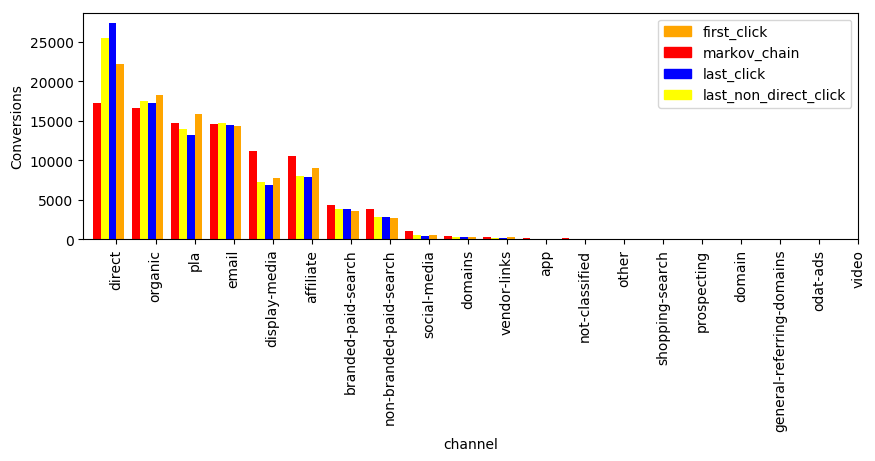

In [81]:
fig = plt.figure(figsize=(10, 3), dpi=100)

ax = fig.add_subplot(111) # Create matplotlib axes

width = 0.2

summary.first_click.plot(kind='bar', color='orange', ax=ax, width=width, position=0)
summary.last_click.plot(kind='bar', color='blue', ax=ax, width=width, position=1)
summary.last_non_direct_click.plot(kind='bar', color='yellow', ax=ax, width=width, position=2)
summary.markov_chain.plot(kind = 'bar', color = "red", ax = ax , width= width, position = 3)

ax.set_ylabel('Conversions')

o = mpatches.Patch(color='orange', label='first_click')
b = mpatches.Patch(color='blue', label='last_click')
y = mpatches.Patch(color='yellow', label='last_non_direct_click')
r = mpatches.Patch(color='red', label='markov_chain')
plt.legend(handles=[o, r, b, y])
plt.savefig("images/markov_chain_attribution_results.png", dpi= fig.dpi)
plt.show()

In [56]:
trace1 = go.Bar(
    x= summary.index,
    y=list(summary['markov_chain'].values),
    name='Markov Chain'
)
trace2 = go.Bar(
    x=summary.index,
    y=list(summary['first_click'].values),
    name='First Click'
)

trace3 = go.Bar(
    x=summary.index,
    y=list(summary['last_non_direct_click'].values),
    name='Last Non Direct Click'
)

trace4 = go.Bar(
    x=summary.index,
    y=list(summary['last_click'].values),
    name='Last Click'
)

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [82]:
for column_name in summary.columns:
    if column_name != "markov_chain":
        summary["markov_chain" +"-"+column_name] = (summary["markov_chain"] - summary[column_name]) * 100 /(summary[column_name])

In [83]:
#Total Conversion


summary[["markov_chain","first_click","last_click","last_non_direct_click"]].sum()

markov_chain             94796.0
first_click              94796.0
last_click               94796.0
last_non_direct_click    94796.0
dtype: float64

### Improvements

- Higher order markov chains
- First Time visitors vs nth time visitor
- Customer Journey Time Boxing 

### Other Applications

- Customer LTV
- Predict prospective buyers
- Natural Language Processing:Ad Copy generation 

In [84]:
##


def channel_bigram(row):
    if ">" in row:
        bigram_final = []
        bigram_list = list(zip(row.split(">")[:-1], row.split(">")[1:]))
        for bigram in bigram_list:
            bigram = (bigram[0].strip(), bigram[1].strip())
            bigram_final.append('#'.join(bigram))
        result = " > ".join(bigram_final)
    else:
        result = row
    return result


## deduping consecutive duplicates


def channel_bigram_dedup(row):
    path_list = row.split(">")
    path_list = [channel.strip() for channel in path_list]
    new_path = " > ".join([x[0] for x in groupby(path_list)])
    return channel_bigram(new_path)

# Question - 3

How should we treat off-line vs. online channels?


<strong>3.1 Statistical Test for Correlation</strong>

#### AOS : Website vs CS

In [85]:

print("Sales dataset has about %d of customer making %d orders\n" 
          %(len(sales.CUSTOMER_ID.unique()), len(sales.CUSTOMER_ID)))

offline_online_sales_share = sales.ORDER_SOURCE_CATEGORY.value_counts(normalize=True) * 100

print("Percentage of Sales from Website : %f"  %offline_online_sales_share["Website"])
print("Percentage of Sales from CS Agents : %f " %offline_online_sales_share["CS"] )

Sales dataset has about 52994 of customer making 76399 orders

Percentage of Sales from Website : 84.299533
Percentage of Sales from CS Agents : 15.700467 


<strong>One-Sample T-Test (Measuring Satisfaction Level)</strong>

A one-sample t-test checks whether a sample mean differs from the population mean

<strong>Hypothesis Testing</strong>: Is there a significant difference in the means of sales amount between purchases made through CS and purchases made through website?

- <strong>Null Hypothesis</strong>: (H0: pTS = pES) The null hypothesis would be that there is no difference in sale amount between purchases which are made through CS and website


- <strong>Alternate Hypothesis</strong>: (HA: pTS != pES) The alternative hypothesis would be that there is a difference in in sale amount between purchases which are made through CS and website

In [86]:
sales_website_mean = sales['SALES'][sales['ORDER_SOURCE_CATEGORY'] == "Website"].mean()
sales_cs_mean = sales['SALES'][sales['ORDER_SOURCE_CATEGORY'] == "CS"].mean()

print( 'The mean sales price for the sales amount made from Website: ' + str(sales_website_mean))
print( 'The mean satisfaction for the sales amount made from CS: ' + str(sales_cs_mean) )

The mean sales price for the sales amount made from Website: 192.3950571393307
The mean satisfaction for the sales amount made from CS: 351.87228928721413


#### Conducting t-test at 95% confidence level

In [87]:
import scipy.stats as stats
stats.ttest_1samp(a=  sales[sales['ORDER_SOURCE_CATEGORY']=="CS"]['SALES'], # Sample of Employee satisfaction who had a Turnover
                  popmean = sales_website_mean)  # Employee Who Had No Turnover satisfaction mean

Ttest_1sampResult(statistic=21.859104800486982, pvalue=6.697916338173568e-104)

In [88]:
degree_freedom = len(sales[sales['ORDER_SOURCE_CATEGORY']=="CS"])

LQ = stats.t.ppf(0.025,degree_freedom)  # Left Quartile

RQ = stats.t.ppf(0.975,degree_freedom)  # Right Quartile

print ('The t-distribution left quartile range is: ' + str(LQ))
print ('The t-distribution right quartile range is: ' + str(RQ))

The t-distribution left quartile range is: -1.96016177583262
The t-distribution right quartile range is: 1.9601617758326195



<strong>T-Test Quantile</strong>

t - statistic value we calculated is 21.86 is outside the quantiles, then we can reject the null hypothesis





<strong>Reject the null hypothesis because:</strong>

- T-Test score is outside the quantiles
- P-value is lower than confidence level of 5%



### Suggestion

1. Predict high AOS customer and customize user experience to include Gear head expert in the user path immedietly
2. High AOS add to cart customers can be pulled for purchase

<strong>3.2 Average visits before conversion: Website vs CS</strong>

In [89]:
n_purchase_source = visits_sales_df[["USER_ID","VISITOR_ID","ORDER_SOURCE_CATEGORY", "PURCHASE_ORDER_NUM"]]
n_purchase_source = n_purchase_source.fillna("NoConv")

In [90]:
purchase_before_visit = n_purchase_source.groupby(["PURCHASE_ORDER_NUM","ORDER_SOURCE_CATEGORY","USER_ID"]).count().reset_index()

In [91]:
purchase_before_visit[purchase_before_visit.PURCHASE_ORDER_NUM == 2]

,PURCHASE_ORDER_NUM,ORDER_SOURCE_CATEGORY,USER_ID,VISITOR_ID
151471,2.0,CS,9456,14
151472,2.0,CS,27448,4
151473,2.0,CS,40770,87
151474,2.0,CS,57449,157
151475,2.0,CS,115090,29
151476,2.0,CS,115612,27
151477,2.0,CS,125576,126
151478,2.0,CS,141265,5
151479,2.0,CS,142552,50
151480,2.0,CS,147212,37


In [92]:
print(purchase_before_visit[purchase_before_visit["ORDER_SOURCE_CATEGORY"] == "CS"].VISITOR_ID.median())
print(purchase_before_visit[purchase_before_visit["ORDER_SOURCE_CATEGORY"] == "Website"].VISITOR_ID.median())

20.0
14.0


[(0, 0.005)]

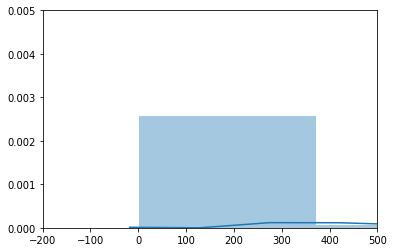

In [70]:
p1 = sns.distplot(np.array(purchase_before_visit[purchase_before_visit["ORDER_SOURCE_CATEGORY"] == "CS"]["VISITOR_ID"]))
p1.set(xlim=(-200, 500))
p1.set(ylim=(0, 0.005))

[(0, 0.001)]

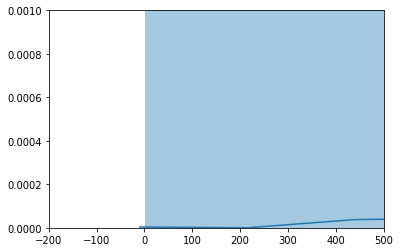

In [71]:
p1 = sns.distplot(np.array(purchase_before_visit[purchase_before_visit["ORDER_SOURCE_CATEGORY"] == "Website"]["VISITOR_ID"]))
p1.set(xlim=(-200, 500))
p1.set(ylim=(0, 0.001))

## Question - 4

Are there combinations of channels that yield better sales results?

In [72]:
##


def channel_bigram(row):
    if ">" in row:
        bigram_final = []
        bigram_list = list(zip(row.split(">")[:-1], row.split(">")[1:]))
        for bigram in bigram_list:
            bigram = (bigram[0].strip(), bigram[1].strip())
            bigram_final.append('#'.join(bigram))
        result = " > ".join(bigram_final)
    else:
        result = row
    return result


## deduping consecutive duplicates


def channel_bigram_dedup(row):
    path_list = row.split(">")
    path_list = [channel.strip() for channel in path_list]
    new_path = " > ".join([x[0] for x in groupby(path_list)])
    return channel_bigram(new_path)

In [73]:
##


user_path_df["CHANNEL_NAME_BIGRAM"] = user_path_df["CHANNEL_NAME"].apply(channel_bigram)
user_path_df["CHANNEL_NAME_BIGRAM_DEDUP"] = user_path_df["CHANNEL_NAME"].apply(channel_bigram_dedup)

In [74]:
##

user_path_df.to_csv("data/user_path_df_final.csv")

In [75]:
markov_chain_results_df = pd.read_csv("data/markov_chain_result_dedup.csv", index_col=0).sort_values(by = "total_conversions", ascending = 0)

In [76]:
markov_channel_combination = markov_chain_results_df.set_index("channel_name")

In [ ]:
fig = plt.figure(figsize=(10, 3), dpi=100)

width = 0.9
markov_channel_combination.total_conversions[:20].plot(kind='bar', color='green', width=width, position=0)

ax.set_ylabel('Conversions')
plt.savefig("images/markov_chain_results_combination.png")
plt.show()

In [93]:
data = [go.Bar(
            x= list(markov_channel_combination.head(20).index),
            y = list(markov_channel_combination.head(20).total_conversions)
    )]

py.iplot(data, filename='basic-bar')

In [54]:
markov_channel_combination.head(10)

,total_conversions
channel_name,
pla#organic,4084.754730
organic#pla,4003.404167
organic#direct,3546.923566
direct#organic,3242.895969
email#direct,3166.327863
direct,3076.388399
direct#email,3048.816073
organic#email,3032.614281
email#organic,3004.261146


# Question - 5 & 6

Given that some channels are considered high cost channels, how might this impact how one might invest resources in each channel?

What other data might you use if available?



<strong>High cost channels:</strong>

- Allocate resources proportional to the attribution models and Cost Per Acqusition
- Taking into consideration future prospects of the channel


<strong>Other Data Sources:</strong>

- Advertising Spend 
- Search Data
- Products Purchased

# Question - 7

How might you recommend shifting resources for high cost channels (e.g. geography or time of day)? 

-  location based targerting

### Web Scraping

https://www.niche.com/

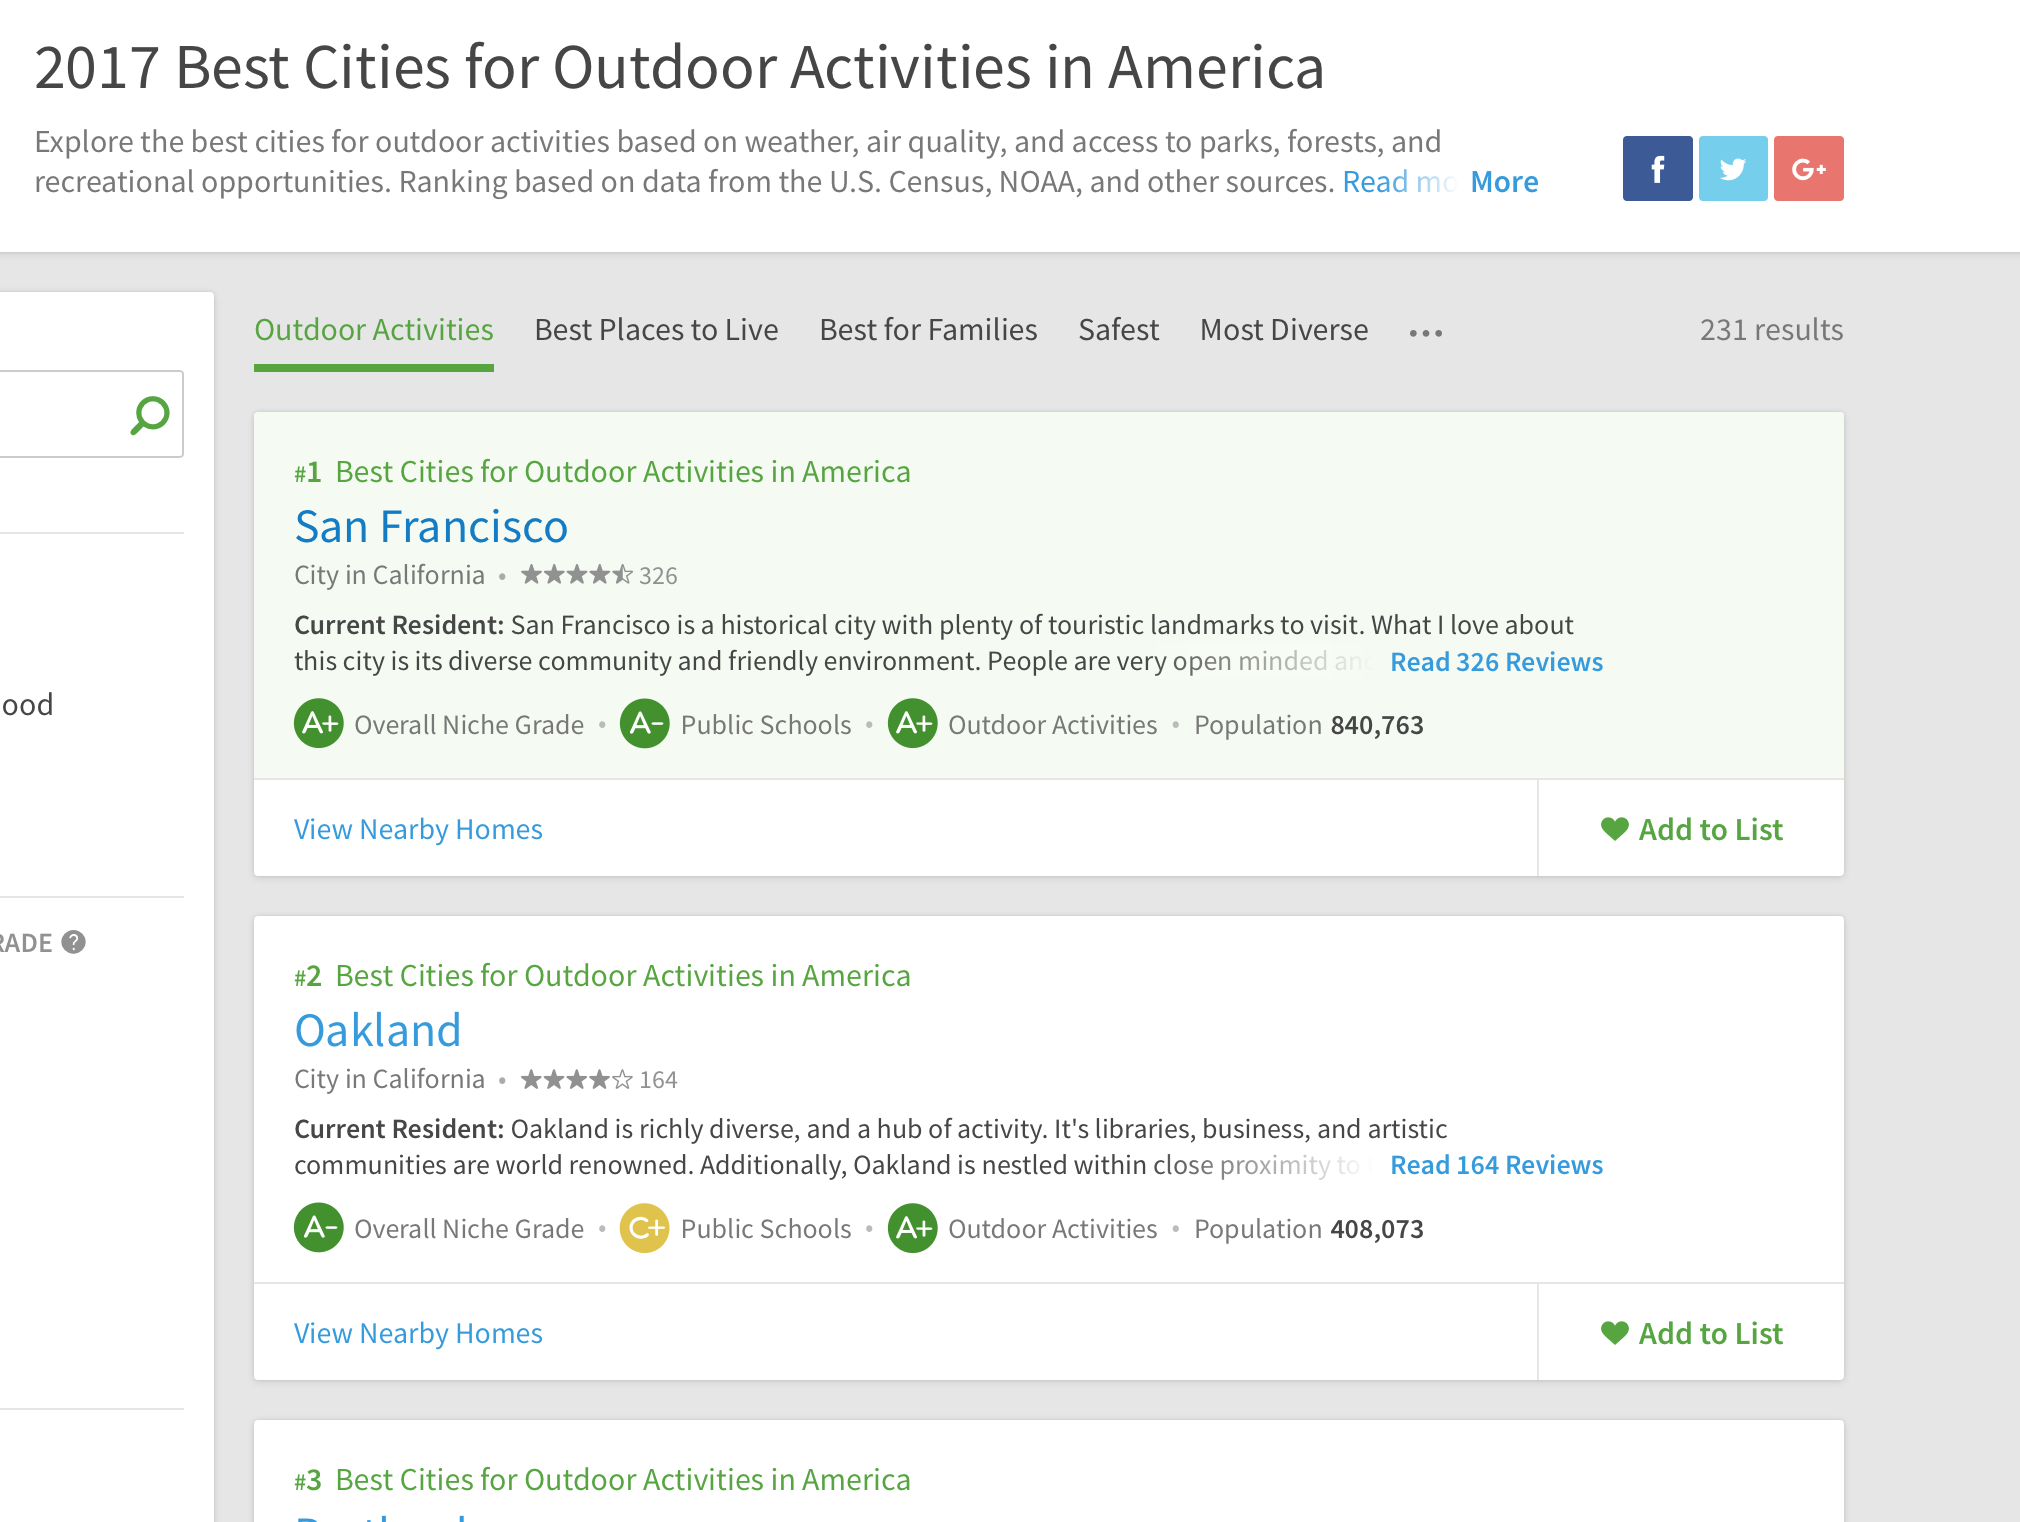

In [55]:
Image(filename="images/niche.png")

In [56]:
##


orders_based_city_ranks = pd.DataFrame(customer_profile.STANDARD_CITY.value_counts()).reset_index()
orders_based_city_ranks = orders_based_city_ranks.rename(columns = {"index":"city","STANDARD_CITY":"total_orders"})
orders_based_city_ranks =  orders_based_city_ranks.sort_values(by = "total_orders", ascending = False)

In [58]:
##


top_outdoor_dest = pd.read_csv("data/top_outdoor_activity_location.csv", index_col=0)

In [69]:
print(orders_based_city_ranks[orders_based_city_ranks["city"] == "New York City"])

print(orders_based_city_ranks[orders_based_city_ranks["city"] == "New York"])

Empty DataFrame
Columns: [city, total_orders]
Index: []
         city  total_orders
0    New York          4555
825  New York            68


In [83]:
orders_based_city_ranks.set_value(825, 'city', "New York")
orders_based_city_ranks = orders_based_city_ranks.groupby("city").sum()
orders_based_city_ranks = orders_based_city_ranks.reset_index().sort_values(by = "total_orders", ascending = False)

In [84]:
##


df = pd.merge(orders_based_city_ranks, top_outdoor_dest, on = "city", how = "inner")
df["total_orders_normalized"] = (df["total_orders"]-df["total_orders"].min())/(df["total_orders"].max()-df["total_orders"].min())
df = df.sort_values(by = "total_orders_normalized", ascending=False)
df["rank_by_order"] = df.reset_index().rename(columns = {"index":"rank_by_order"})["rank_by_order"] + 1
df["rank_diff"] = df["rank_by_order"] - df["rank"]
df = df.sort_values(by = "rank_diff")
top_bottom_10 = pd.concat([df.head(10), df.tail(10)])

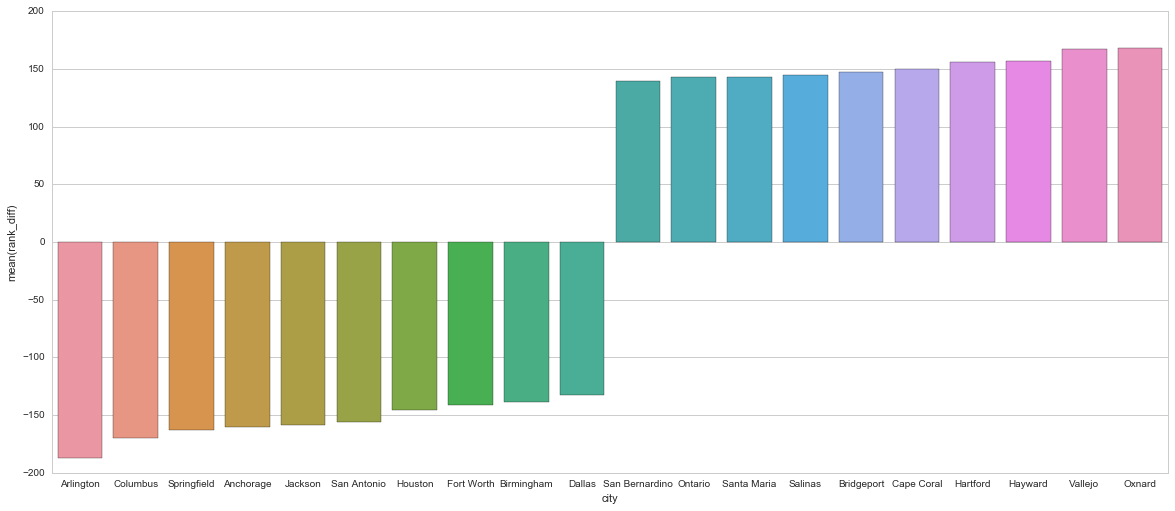

In [87]:
## Plotting opportunity graph


sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(20, 8.27)
ax = sns.barplot(x="city", y="rank_diff", data=top_bottom_10)
plt.savefig("images/opportunity_graph.png")

In [85]:
df

,city,total_orders,rank,state,total_orders_normalized,rank_by_order,rank_diff
18,Arlington,1031,206,Texas,0.232264,19,-187
32,Columbus,780,203,Georgia,0.175554,33,-170
53,Springfield,566,217,Illinois,0.127203,54,-163
35,Anchorage,713,196,Alaska,0.160416,36,-160
30,Jackson,798,190,Mississippi,0.179620,31,-159
47,San Antonio,608,204,Texas,0.136692,48,-156
9,Houston,1815,156,Texas,0.409399,10,-146
82,Fort Worth,372,224,Texas,0.083371,83,-141
68,Birmingham,451,208,Alabama,0.101220,69,-139
13,Dallas,1212,147,Texas,0.273159,14,-133


<strong>What else?</strong>

- Can change this analysis into more glanular: zipcode level targeting
- Using internal search data & external search data, regional specific product advertisting can be carried out
- Create customer profile based on type of products they purchase and target accordingly 

References:

https://cran.r-project.org/web/packages/ChannelAttribution/ChannelAttribution.pdf<br>
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2685167

- Mapping the Customer Journey: Lessons Learned from Graph-Based Online Attribution Modeling by Eva Anderl, Ingo Becker, Florian von Wangenheim, Jan Hendrik Schumann

In [91]:
Image(url="https://www.carlocab.com/wp-content/uploads/2007/11/halloween.jpg")

 jupyter nbconvert data-wrangling.ipynb --to slides --post serve

Github : https://github.com/jonamjar/bc-project